# Séparation de sources

## Dataset

Nous allons utiliser le dataset [ MUSDB18](https://sigsep.github.io/datasets/musdb.html), qui contient 150 morceaux de musiques ainsi qu'une séparation en 4 pistes (basse, batterie, chant et autre). Ces données sont compréssées, échantillonées à $44.1kHz$ et en stéréo. Nous les ré-échantillonerons et les convertirons en mono pour accélérer les calculs. Comme importer ce dataset dans Google Colab serait trop long, nous travaillerons aussi sur des extraits de 7 secondes de chaque morceau.

Nous allons utiliser la librairie Python [`musdb`](https://github.com/sigsep/sigsep-mus-db) qui permet de manipuler ces données simplement.

In [ ]:
!pip install musdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.5/963.5 kB 18.0 MB/s eta 0:00:00


In [ ]:
import musdb
mus = musdb.DB(download=True)

Done!


## Modèle

Nous allons implémenter le U-NET présenté dans le papier [`SINGING VOICE SEPARATION WITH DEEP U-NET CONVOLUTIONAL
NETWORKS`](https://ejhumphrey.com/assets/pdf/jansson2017singing.pdf).

Voici l'architecture du réseau $:$

![](https://d3i71xaburhd42.cloudfront.net/83ea11b45cba0fc7ee5d60f608edae9c1443861d/3-Figure1-1.png)

- chaque bloc de descente est constitué :
    - d'une couche de convolution 2D, avec un *stride* de 2 (ce qui a pour effet de diviser la longueur et la largeur par 2) et un noyau de taille $ 5 \times 5 $
    - d'une couche de *BatchNormalization*
    - d'une activation de type *LeakyRelu* avec un paramètre $\alpha = 0.2$
- chaque bloc de remontée est constitué :
    - d'une couche de déconvolution 2D ($conv2DTranspose$), avec un *stride* de 2 (ce qui a pour effet de multiplier la longueur et la largeur par 2) et un noyau de taille $ 5 \times 5 $
    - d'une couche de concaténation avec la sortie du bloc de descente correspondant
    - d'une activation de type *LeakyRelu*
- enfin, le bloc de sortie est constitué 
    - d'une couche déconvolution 2D ($conv2DTranspose$) avec autant de filtres que d'instruments à séparer
    - d'une couche de multiplication entre ces filtres et le sonagramme passé en entrée du réseau



In [ ]:
import tensorflow as tf

In [ ]:
kernel_size = (5,5)
strides = 2

input_layer = tf.keras.layers.Input(shape=(512, 128, 1))

conv1 = tf.keras.layers.Conv2D(filters=16, kernel_size=kernel_size, strides=strides, padding='same')(input_layer)
batch1 = tf.keras.layers.BatchNormalization()(conv1)
activ1 = tf.keras.layers.LeakyReLU(alpha=0.2)(batch1)

conv2 = tf.keras.layers.Conv2D(filters=32, kernel_size=kernel_size, strides=strides, padding='same')(activ1)
batch2 = tf.keras.layers.BatchNormalization()(conv2)
activ2 = tf.keras.layers.LeakyReLU(alpha=0.2)(batch2)

conv3 = tf.keras.layers.Conv2D(filters=64, kernel_size=kernel_size, strides=strides, padding='same')(activ2)
batch3 = tf.keras.layers.BatchNormalization()(conv3)
activ3 = tf.keras.layers.LeakyReLU(alpha=0.2)(batch3)

conv4 = tf.keras.layers.Conv2D(filters=128, kernel_size=kernel_size, strides=strides, padding='same')(activ3)
batch4 = tf.keras.layers.BatchNormalization()(conv4)
activ4 = tf.keras.layers.LeakyReLU(alpha=0.2)(batch4)

conv5 = tf.keras.layers.Conv2D(filters=256, kernel_size=kernel_size, strides=strides, padding='same')(activ4)
batch5 = tf.keras.layers.BatchNormalization()(conv5)
activ5 = tf.keras.layers.LeakyReLU(alpha=0.2)(batch5)

conv6 = tf.keras.layers.Conv2D(filters=512, kernel_size=kernel_size, strides=strides, padding='same')(activ5)
batch6 = tf.keras.layers.BatchNormalization()(conv6)
activ6 = tf.keras.layers.LeakyReLU(alpha=0.2)(batch6)

up5 = tf.keras.layers.Conv2DTranspose(filters=256, kernel_size=kernel_size, strides=strides, padding='same')(activ6)
conc5 = tf.keras.layers.Concatenate()([up5, activ5])
uactiv5 = tf.keras.layers.LeakyReLU()(conc5)

up4 = tf.keras.layers.Conv2DTranspose(filters=128, kernel_size=kernel_size, strides=strides, padding='same')(uactiv5)
conc4 = tf.keras.layers.Concatenate()([up4, activ4])
uactiv4 = tf.keras.layers.LeakyReLU()(conc4)

up3 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=kernel_size, strides=strides, padding='same')(uactiv4)
conc3 = tf.keras.layers.Concatenate()([up3, activ3])
uactiv3 = tf.keras.layers.LeakyReLU()(conc3)

up2 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=kernel_size, strides=strides, padding='same')(uactiv3)
conc2 = tf.keras.layers.Concatenate()([up2, activ2])
uactiv2 = tf.keras.layers.LeakyReLU()(conc2)

up1 = tf.keras.layers.Conv2DTranspose(filters=16, kernel_size=kernel_size, strides=strides, padding='same')(uactiv2)
conc1 = tf.keras.layers.Concatenate()([up1, activ1])
uactiv1 = tf.keras.layers.LeakyReLU()(conc1)

mask = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=kernel_size, strides=strides, padding='same')(uactiv1)
output_layer = tf.keras.layers.Multiply()([input_layer, mask])

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 256, 64, 16)  416         ['input_2[0][0]']                
                                                                                                  
 batch_normalization_6 (BatchNo  (None, 256, 64, 16)  64         ['conv2d_6[0][0]']               
 rmalization)                                                                                     
                                                                                            

## Préparation des données

In [ ]:
import tqdm
import numpy as np
import librosa
n = 100
X = np.empty((n, 512, 128, 1), dtype=complex)
Y = np.empty((n, 512, 128, 1), dtype=complex)

def preprocess(y):
    # Conversion en mono
    y = np.mean(y, 1)
    
    # Ré-échantillonage
    y = librosa.resample(y, orig_sr=44100, target_sr=8192*2)

    # Calcul de la TFCT
    Y = librosa.stft(y, n_fft=1024, hop_length=768)
    Y = Y[:512, 0:128]
    return Y

for i in tqdm.tqdm(range(n)):
    X[i, :, :, 0] = preprocess(mus[i].targets['vocals'].audio)
    Y[i, :, :, 0] = preprocess(mus[i].targets['drums'].audio + mus[i].targets['other'].audio + mus[i].targets['bass'].audio)

100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


In [ ]:
class DataGenerator(tf.keras.utils.Sequence) :

    def __init__(self, X, Y, batch_size):
        self.batch_size = batch_size
        self.X = X
        self.Y = Y
        self.n = X.shape[0]

        self.x = np.empty((self.batch_size, 512, 128, 1))
        self.y = np.empty((self.batch_size, 512, 128, 1))

    def __getitem__(self, index):
        indexes = np.array(range(index * self.batch_size, (index+1) * self.batch_size))
        i_s = indexes // self.n
        j_s = indexes % self.n
        
        self.x = np.abs(self.X[j_s] + self.Y[i_s])**2
        self.x /= np.max(self.x)
        self.y = np.abs(self.Y[i_s])**2
        self.y /= np.max(self.y)

        return self.x, self.y

    def __len__(self): 
        return int(np.floor(self.n**2 / self.batch_size))

In [ ]:
x_train_gen = DataGenerator(X[:90], Y[:90], 20)
x_val_gen = DataGenerator(X[90:n], Y[90:n], 20)

## Entraînement

In [ ]:
model.compile(
    loss=['mse'],
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3)
)


history = model.fit(
	x=x_train_gen,
	validation_data=x_val_gen,
	epochs=10,
)

Epoch 1/3
405/405 [==============================] - 46s 97ms/step - loss: 5.2716e-06 - val_loss: 2.0981e-05
Epoch 2/3
405/405 [==============================] - 38s 95ms/step - loss: 6.0535e-06 - val_loss: 2.6403e-05
Epoch 3/3
405/405 [==============================] - 38s 93ms/step - loss: 5.8446e-06 - val_loss: 1.8188e-05


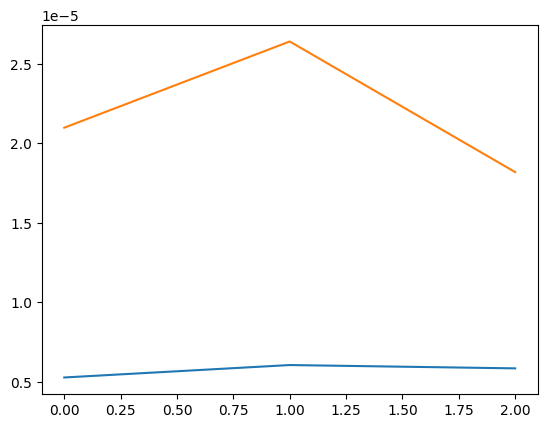

In [ ]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

## Prédictions

In [ ]:
id = 10

x_test, x_phase_test = librosa.magphase(preprocess(mus[id].audio))
y_test, _ = librosa.magphase(preprocess(mus[id].targets['vocals'].audio))

Y_mix = x_test * x_phase_test
y_mix = librosa.istft(Y_mix, hop_length=768)

Y_true = y_test * x_phase_test
y_true = librosa.istft(Y_true, hop_length=768)

pred = model.predict(x_test[np.newaxis, :])
S = pred[0, :, :, 0]
Y_pred = S * x_phase_test
Y_pred = np.vstack([Y_pred, np.zeros((1, Y_pred.shape[1]))])
y_pred = librosa.istft(Y_pred, hop_length=768)

1/1 [==============================] - 0s 246ms/step


In [ ]:
import IPython.display as ipd
print('Mixture :')
ipd.display(ipd.Audio(y_mix, rate=8192*2))
print('Vocals :')
ipd.display(ipd.Audio(y_true, rate=8192*2))
print('Predicted vocals :')
ipd.display(ipd.Audio(y_pred, rate=8192*2))

Mixture :


Vocals :


Predicted vocals :
